In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
import mne
from nice.algorithms.connectivity import epochs_compute_wsmi
from scipy.stats import zscore
from scipy.signal import detrend
import copy
np.set_printoptions(threshold=100)  # Default threshold
mne.set_log_level('WARNING')
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

def preprocess(data):
    data = detrend(data, axis=0)
    epsilon = 1e-9
    data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
    return data


#making the data structures to store 
run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)

agg_structure = {f'dataset_{file_number}': 
                 {f'left_class_{class_left}': 
                  {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

left_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
right_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
attention_LFP_attleft_agg = copy.deepcopy(agg_structure)

left_input_LFP_attright_agg = copy.deepcopy(agg_structure)
right_input_LFP_attright_agg = copy.deepcopy(agg_structure)
attention_LFP_attright_agg = copy.deepcopy(agg_structure)

n_values = {f'dataset_{file_number}':
            {f'left_class_{class_left}':
             {f'right_class_{class_right}': {
                'attleft': [],
                'attright': []
                } for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}


#loading the data by class combinations
total_time = time.time()
total_load_time = time.time()
for file_number in file_numbers:   #will first load the file & extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")
    file_process_time = time.time()

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]

    print(data['LFP'][0][0].shape)
    print("NaNs before preprocessing:", np.isnan(data['LFP'][0][0][relevant]).sum())

    # Extract LFP signals
    left_input_LFP = preprocess(data['LFP'][0][0][relevant])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant])

    print(np.mean(left_input_LFP, axis=0)[0:30])
    print(np.std(left_input_LFP, axis=0)[0:30])

    print(relevant.shape)
    print(left_input_LFP.shape)

    for class_left in classes_left:
        for class_right in classes_right: 
            left_indices_LR = np.where((omitted == 0) & (attend_01 == 0) & (label_left == class_left) & (label_right == class_right))[0]  
            left_indices = np.where(np.isin(relevant, left_indices_LR))[0]

            
            right_indices_LR = np.where((omitted == 0) & (attend_01 == 1) & (label_left == class_left) & (label_right == class_right))[0]
            right_indices = np.where(np.isin(relevant, right_indices_LR))[0]


            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attright'] = [len(right_indices)]  #nb need both left & right indices to be non empty


            if len(left_indices) >= 1:
                left_input_LFP_attleft = left_input_LFP[left_indices]
                right_input_LFP_attleft = right_input_LFP[left_indices]
                attention_LFP_attleft = attention_LFP[left_indices]

                left_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_input_LFP_attleft)
                right_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_input_LFP_attleft)
                attention_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_LFP_attleft)

            if len(right_indices) >= 1:

                left_input_LFP_attright = left_input_LFP[right_indices]
                right_input_LFP_attright = right_input_LFP[right_indices]
                attention_LFP_attright = attention_LFP[right_indices]

                left_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_input_LFP_attright)   
                right_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_input_LFP_attright)
                attention_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_LFP_attright)

    del data
    gc.collect()
    elapsed_time = time.time() - file_process_time
    print(f"Dataset {file_number} processed in {elapsed_time:.2f} seconds")

n_values_sum = {f'left_class_{class_left}': {f'right_class_{class_right}': {'attleft': 0, 'attright': 0} for class_right in classes_right} for class_left in classes_left}

for class_left in classes_left:
    for class_right in classes_right:
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'][0] for dataset in file_numbers  #this will check through all the datasets 
        )
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attright'][0] for dataset in file_numbers
        )


Dataset 1 loaded in 9.21 seconds
(2032, 500)
NaNs before preprocessing: 0
[ 0.00000000e+00  5.98701158e-18  2.66789639e-17 -2.79393874e-17
 -3.34012225e-17  1.74358583e-17  2.03768464e-17 -1.89063524e-17
 -3.60796224e-17 -2.01667758e-17  2.52084698e-18 -3.31911519e-17
  3.04602344e-18  2.09020229e-17 -8.08771740e-17  1.52301172e-17
 -2.67839992e-17  5.25176454e-20 -3.71824930e-17 -1.58603289e-17
 -1.17639526e-17 -3.62371754e-17  3.61321401e-17 -4.36946810e-17
 -5.20975043e-17  3.44515754e-17  4.97867279e-17  3.34012225e-17
  9.87331734e-18 -2.18473405e-17]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
(1057,)
(1057, 500)
Dataset 1 processed in 3.16 seconds
Dataset 2 loaded in 7.12 seconds
(2032, 500)
NaNs before preprocessing: 0
[ 0.00000000e+00  3.65588592e-17 -7.31177184e-17  3.58859968e-18
  2.10830231e-17 -6.36976442e-17  3.20731096e-17 -2.82602224e-17
 -1.88401483e-17  1.57001236e-17  2.64659226e-17 -2.89330849e-17
 -6.72862439e-18 -9

In [64]:
#checking for nan values in aggeragte data
def check_for_nan(data_dict):
    for dataset in data_dict:
        for left_class in data_dict[dataset]:
            for right_class in data_dict[dataset][left_class]:
                for array in data_dict[dataset][left_class][right_class]:
                    if np.isnan(array).any():
                        print(f'NaN values found in {dataset} -> {left_class} -> {right_class}')

check_for_nan(left_input_LFP_attleft_agg)
check_for_nan(right_input_LFP_attleft_agg)
check_for_nan(attention_LFP_attleft_agg)

check_for_nan(left_input_LFP_attright_agg)
check_for_nan(right_input_LFP_attright_agg)
check_for_nan(attention_LFP_attright_agg)

Below I split the data for later and attention, both preprocessed and not

Total load time = 128.41 seconds
attention_input_LFP_attleft_all 01 raw = [[ 0.          0.          0.         ... -0.1536151  10.2182568
  -0.10480474]
 [ 0.          0.          0.         ... -0.14302813 -0.13807095
  -0.11780113]
 [ 0.          0.          0.         ... -0.10212434 -0.12589699
  -0.12563739]
 ...
 [ 0.          0.          0.         ... -0.11531545 -0.12920005
  -0.15635011]
 [ 0.          0.          0.         ... -0.10895617 -0.11932195
  -0.16026125]
 [ 0.          0.          0.         ...  5.30099274 -0.10915753
  -0.16428576]]
checking 01:---------------------- [[ 0.          0.          0.         ... -0.1536151  10.2182568
  -0.10480474]
 [ 0.          0.          0.         ... -0.14302813 -0.13807095
  -0.11780113]
 [ 0.          0.          0.         ... -0.10212434 -0.12589699
  -0.12563739]
 ...
 [ 0.          0.          0.         ... -0.11531545 -0.12920005
  -0.15635011]
 [ 0.          0.          0.         ... -0.10895617 -0.11932195
  -0.1

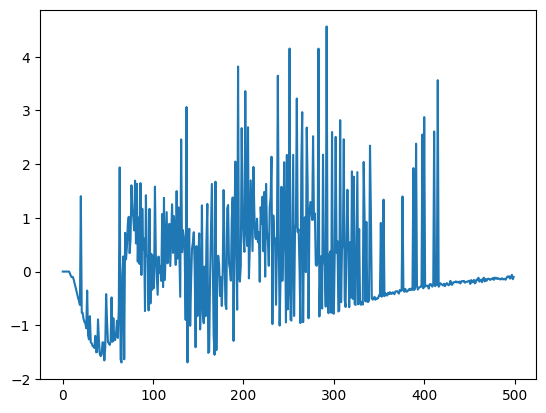

In [66]:
#dont want to process here - want to process when its in the big array
print(f'Total load time = {time.time() - total_load_time:.2f} seconds')

#-------formatting the trials into a single array for each class pair, of length n_samples * n_trials------------------
all_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left}

left_input_LFP_attleft_all = copy.deepcopy(all_structure)
right_input_LFP_attleft_all = copy.deepcopy(all_structure)
attention_LFP_attleft_all = copy.deepcopy(all_structure)

left_input_LFP_attright_all = copy.deepcopy(all_structure)
right_input_LFP_attright_all = copy.deepcopy(all_structure)
attention_LFP_attright_all = copy.deepcopy(all_structure)

for filenumber in file_numbers:
    for class_left in classes_left:
        for class_right in classes_right:
            left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

#------ want to preprocess each array here now that they are properly compiled ----------------
#looking first at the shape / structure of left_input_LFP_attleft_all:

for class_left in classes_left:
        for class_right in classes_right:
            left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

print('attention_input_LFP_attleft_all 01 raw =', attention_LFP_attleft_all[f'left_class_{0}'][f'right_class_{1}'])

print('checking 01:----------------------', attention_LFP_attleft_all[f'left_class_{0}'][f'right_class_{1}'])
plt.plot(attention_LFP_attleft_all[f'left_class_{14}'][f'right_class_{7}'][0])
plt.show()

left_attleft = copy.deepcopy(all_structure)
right_attleft = copy.deepcopy(all_structure)
att_attleft = copy.deepcopy(all_structure)

left_attright = copy.deepcopy(all_structure)
right_attright = copy.deepcopy(all_structure)
att_attright = copy.deepcopy(all_structure)

for class_left in classes_left:
    for class_right in classes_right:
        left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = (left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = (right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = (attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

        left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = (left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = (right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = (attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

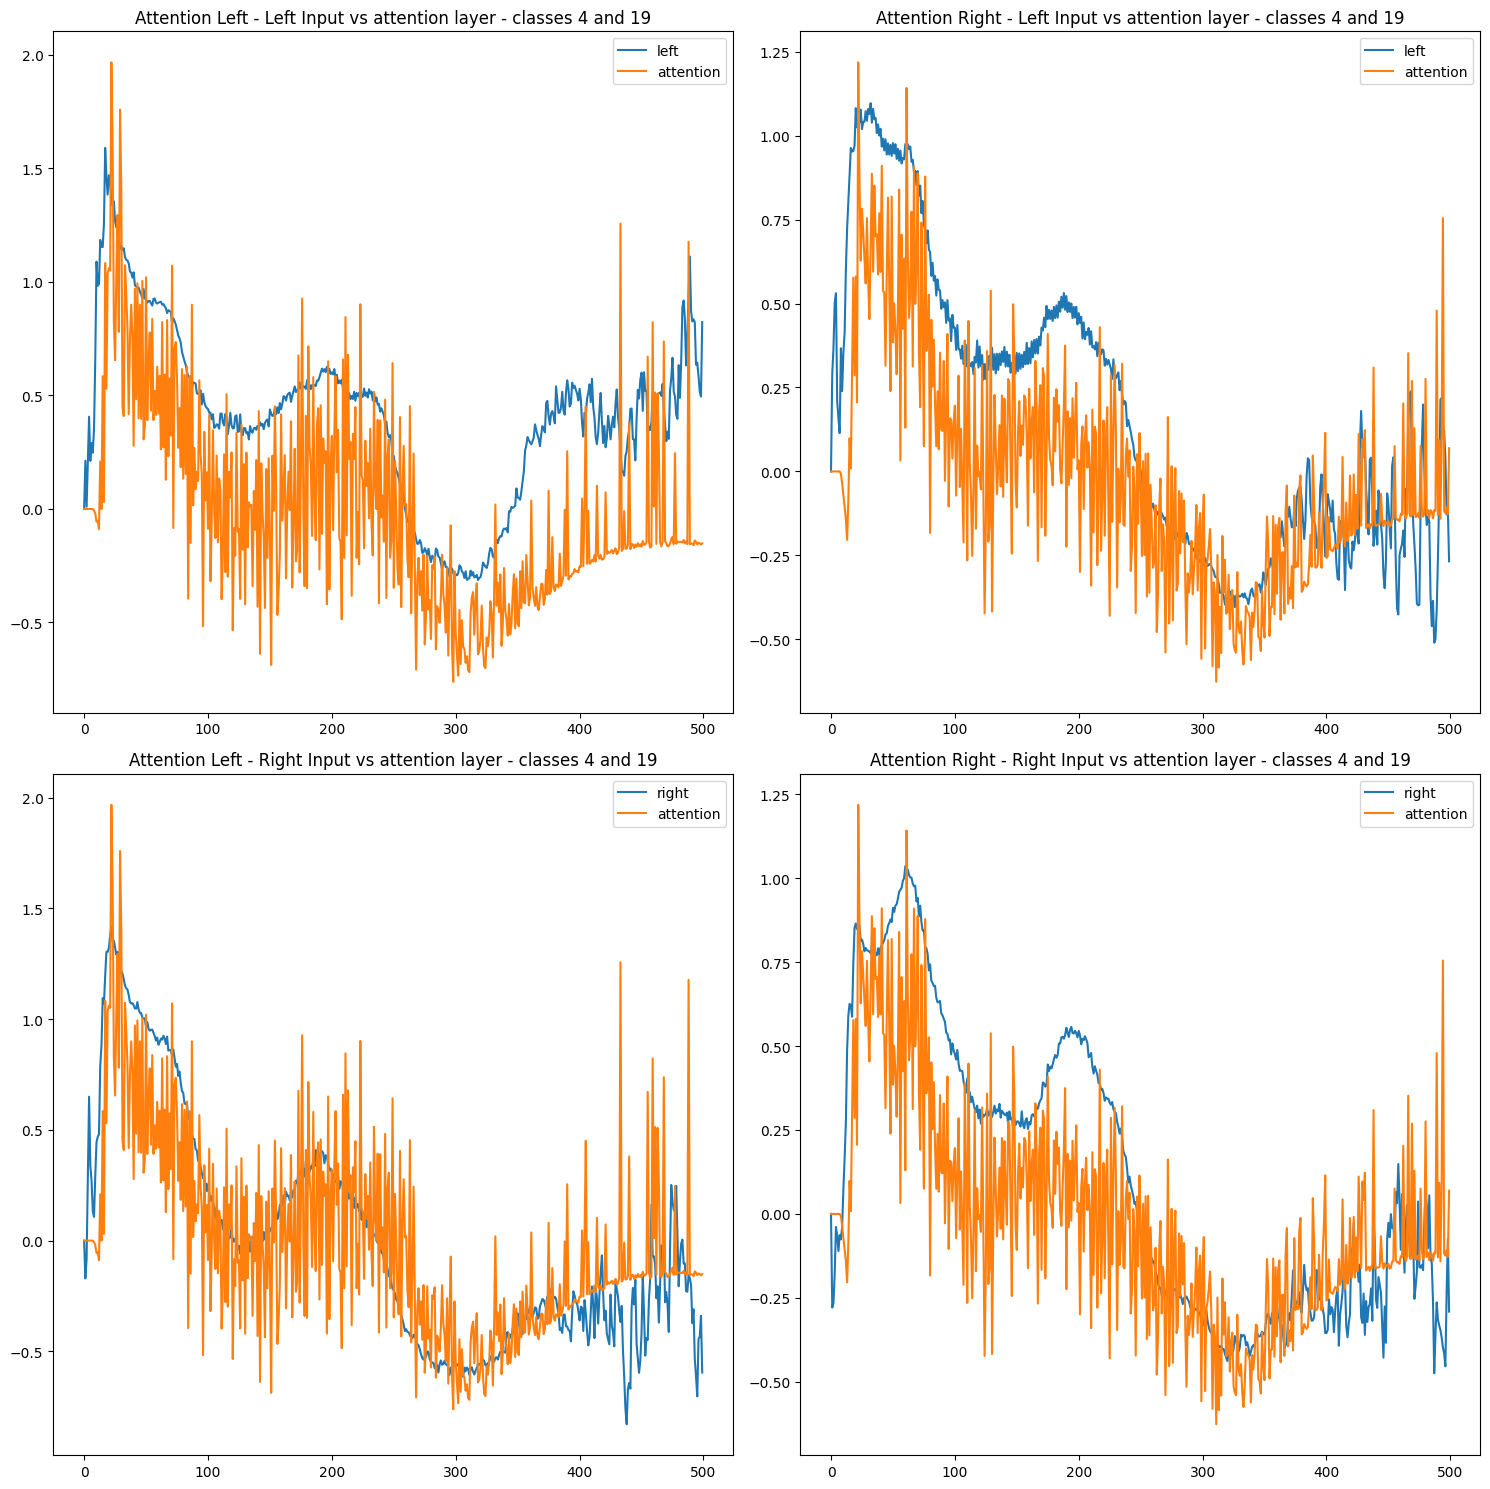

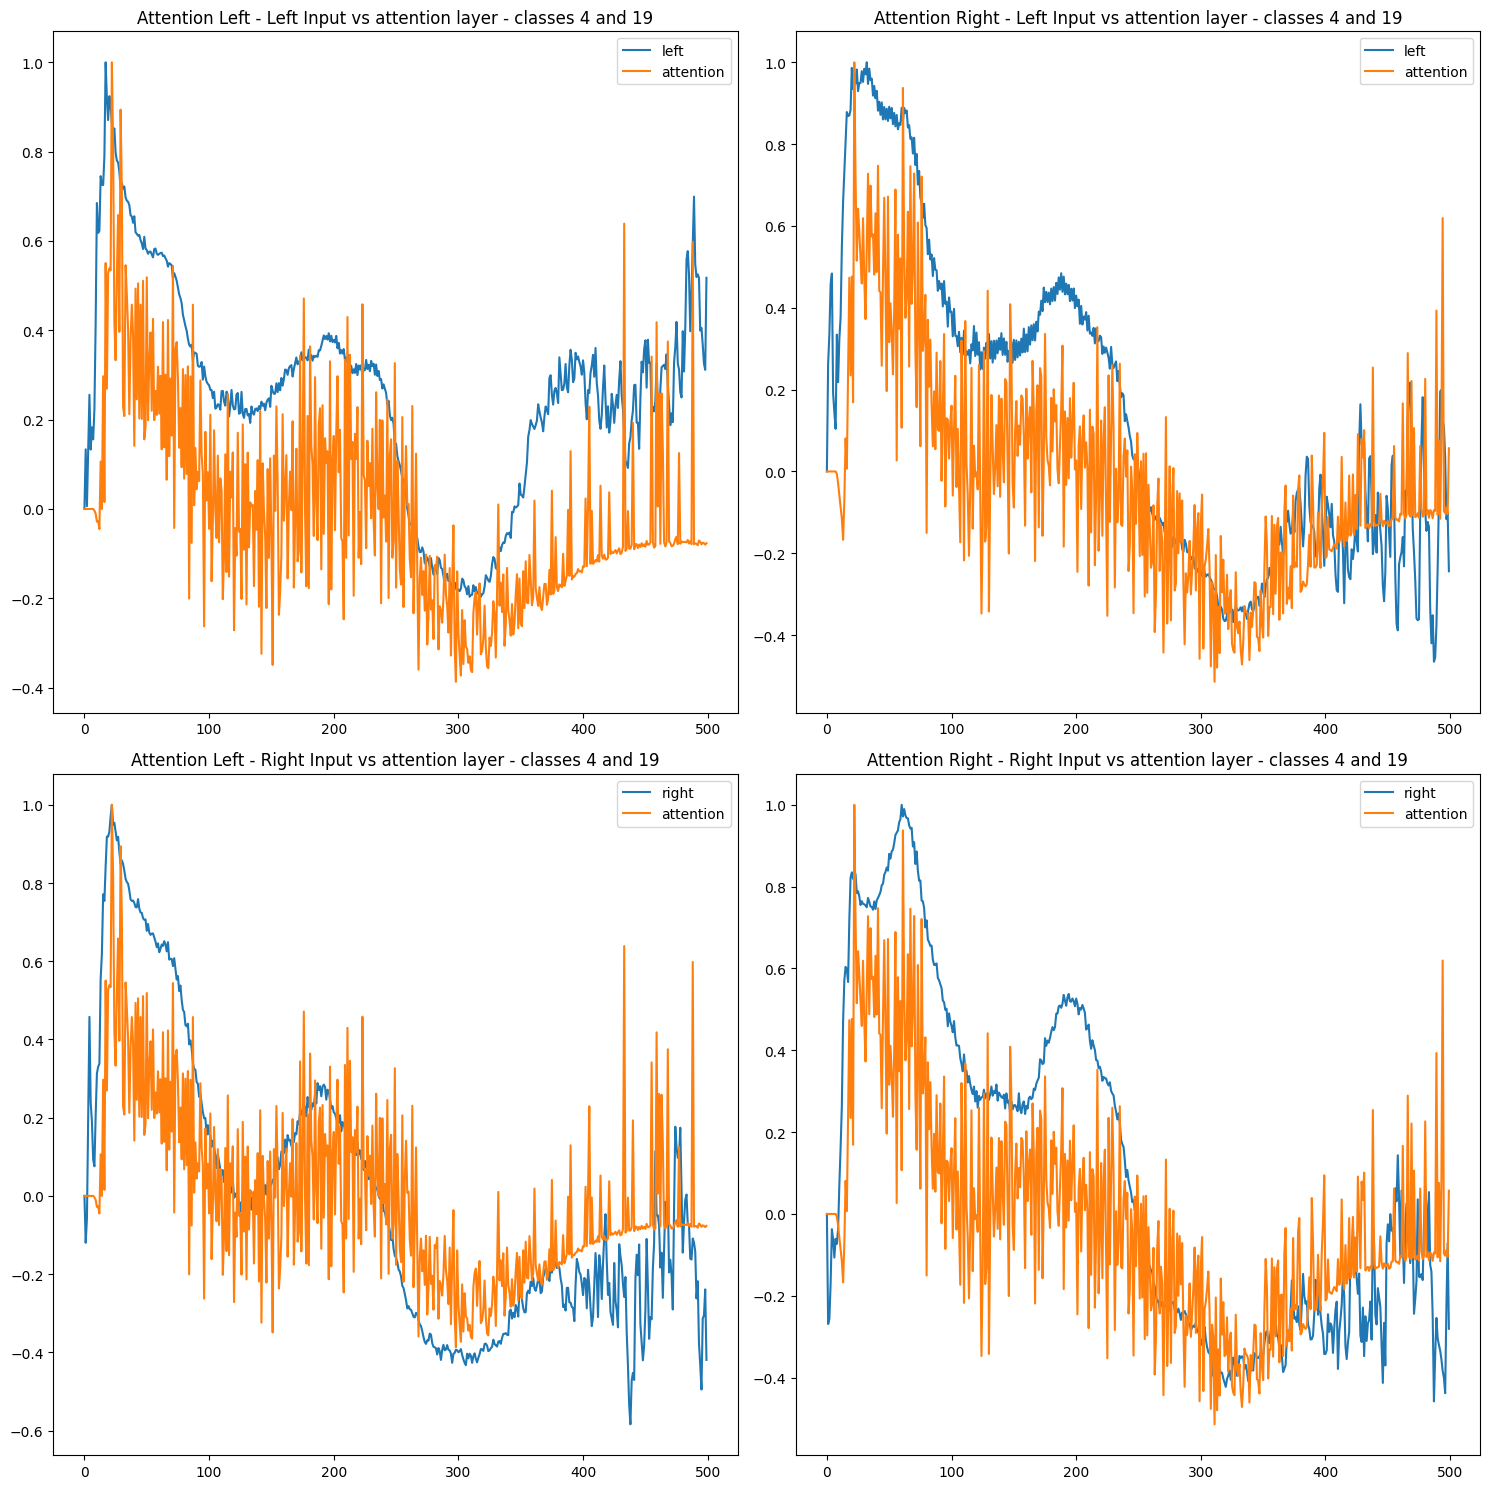

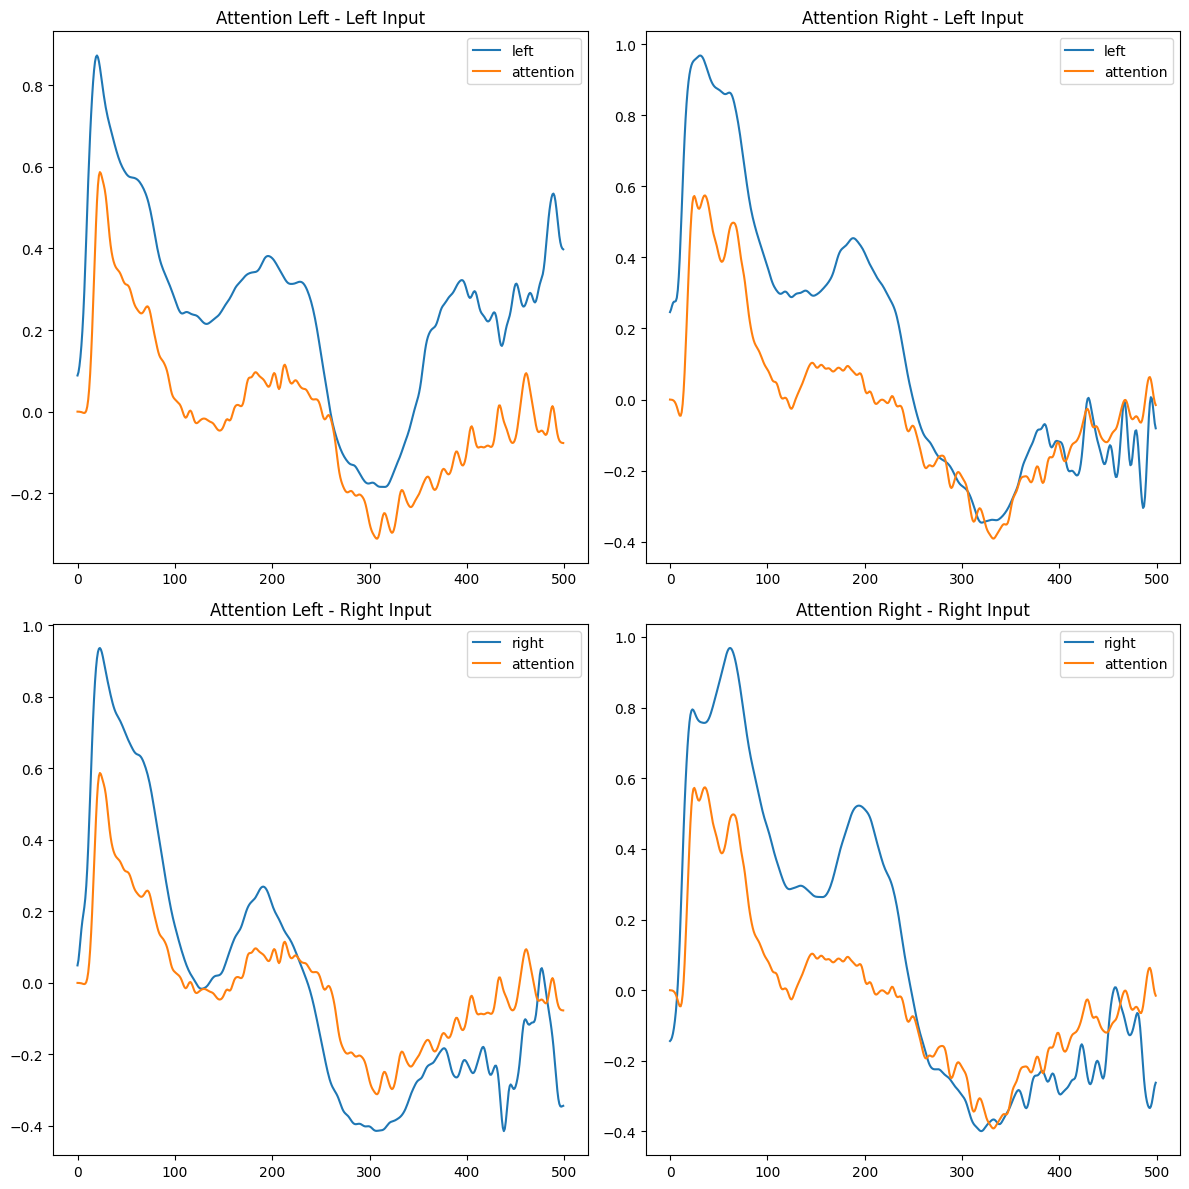

In [71]:
#---------------not processed-------------------
mean_left_attleft = copy.deepcopy(all_structure)
mean_right_attleft = copy.deepcopy(all_structure)
mean_attention_attleft = copy.deepcopy(all_structure)

mean_left_attright = copy.deepcopy(all_structure)
mean_right_attright = copy.deepcopy(all_structure)
mean_attention_attright = copy.deepcopy(all_structure)


#here take mean across all trials for each class pair
for class_left in classes_left:
    for class_righti in classes_right:
        mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = np.mean(left_attleft[f'left_class_{class_left}'][f'right_class_{class_left}'], axis = 0)
        mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(right_attleft[f'left_class_{class_left}'][f'right_class_{class_left}'], axis = 0)
        mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(att_attleft[f'left_class_{class_left}'][f'right_class_{class_left}'], axis = 0)

        mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)
        mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)
        mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)


##will select a class pair and plot the traces 
left, right = 4, 19
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

ax[0, 0].plot(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 0].set_title(f'Attention Left - Left Input vs attention layer - classes {left} and {right}')
ax[0, 0].legend()

ax[1, 0].plot(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 0].set_title(f'Attention Left - Right Input vs attention layer - classes {left} and {right}')
ax[1, 0].legend()

ax[0, 1].plot(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 1].set_title(f'Attention Right - Left Input vs attention layer - classes {left} and {right}')
ax[0, 1].legend()

ax[1, 1].plot(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 1].set_title(f'Attention Right - Right Input vs attention layer - classes {left} and {right}')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

#-------------not processes, normalised
def norm(data):
    return data / np.max(data)

mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])

mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])

fig, ax = plt.subplots(2, 2, figsize=(15, 15))

ax[0, 0].plot(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 0].set_title(f'Attention Left - Left Input vs attention layer - classes {left} and {right}')
ax[0, 0].legend()

ax[1, 0].plot(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 0].set_title(f'Attention Left - Right Input vs attention layer - classes {left} and {right}')
ax[1, 0].legend()

ax[0, 1].plot(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 1].set_title(f'Attention Right - Left Input vs attention layer - classes {left} and {right}')
ax[0, 1].legend()

ax[1, 1].plot(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 1].set_title(f'Attention Right - Right Input vs attention layer - classes {left} and {right}')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

#----------not processed and smoothed---------------
from scipy.ndimage import gaussian_filter1d
def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma) 

mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] )
mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] )

mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] )
mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] )
mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] )

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 0].set_title('Attention Left - Left Input')
ax[0, 0].legend()

ax[1, 0].plot(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 0].set_title('Attention Left - Right Input')
ax[1, 0].legend()

ax[0, 1].plot(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 1].set_title('Attention Right - Left Input')
ax[0, 1].legend()

ax[1, 1].plot(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 1].set_title('Attention Right - Right Input')
ax[1, 1].legend()

plt.tight_layout()
plt.show()



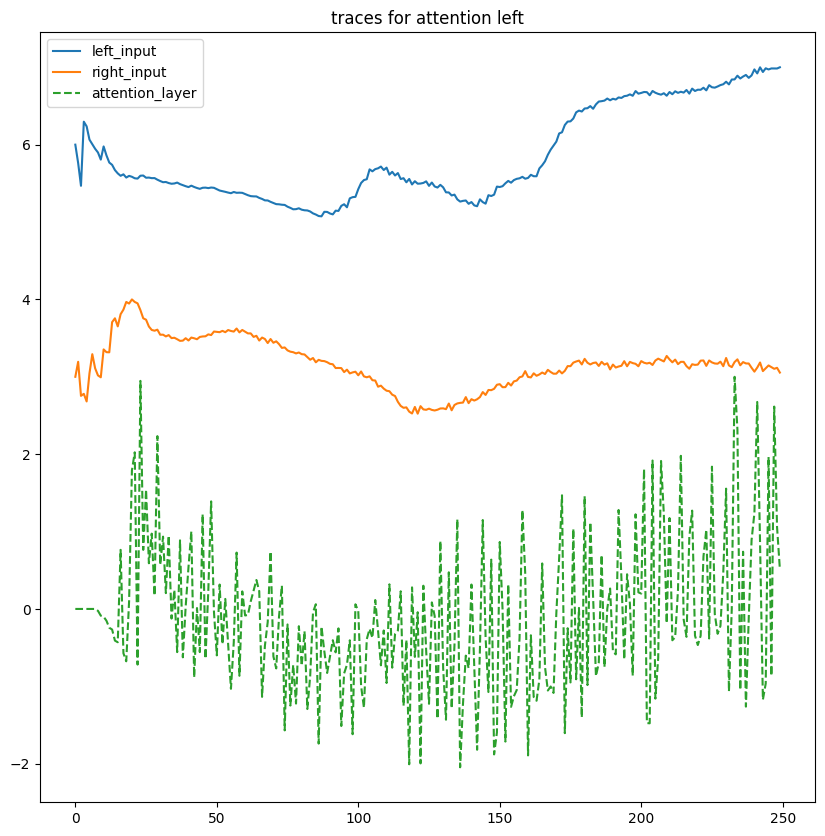

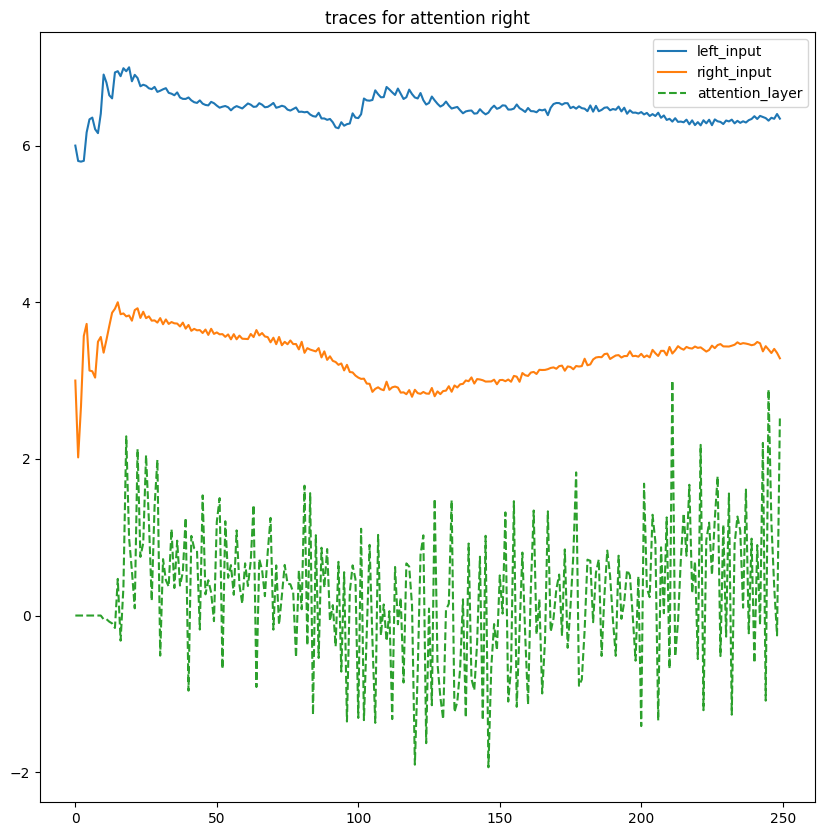

In [69]:
#-------------wsmi calculation----------------
n_times = 250
dt = 0.002
sfreq = 1 / dt

ch_names = ['left_input', 'right_input', 'attention_layer']
ch_types = ['eeg', 'eeg', 'eeg']
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

lr_split_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for class_right in classes_right} for class_left in classes_left}


for class_left in classes_left:
    wsmi_start = time.time()
    for class_right in classes_right: 
     
        #reshaping data for attention left
        raw_data_left = np.concatenate([
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'], 
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] ,
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] 
            ], axis=0)

        #print("raw_data_left shape =", raw_data_left.shape)  
        #Reshape into (n_channels, n_samples)
        raw_data_left = raw_data_left.reshape(3, -1)  
        #print('raw data left reshaped =', raw_data_left.shape) 
        raw_left = mne.io.RawArray(raw_data_left, info)
        #print("raw_data_left =", raw_left)


        events_left = np.array([[i * n_times, 0, 1] for i in range(n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft']) ])
        epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.498, baseline=None, preload=True)

        # if class_left == 0 and class_right == 1:
        #     print('raw_data_left =', raw_data_left)
        #     print('raw_data_left reshaped =', raw_data_left.shape)
        #     print('raw_left =', raw_left)
        #     #defininf event objects, arrays like [0,0,1], [500, 0, 1], [1000, 0, 1] etc
        #     epochs_left.plot(n_epochs = 2, n_channels=3, scalings = 'auto', title="Attention Left")
        #     plt.show()

        if class_left == left and class_right == right:
            plt.figure(figsize=(10, 10))
            NL = np.max(raw_data_left[0][0:250])
            NR = np.max(raw_data_left[1][0:250])
            NA = np.max(raw_data_left[2][0:250])
            plt.plot((raw_data_left[0][0:250] / NL)+6, label='left_input')
            plt.plot((raw_data_left[1][0:250] / NR)+3, label='right_input')
            plt.plot(3 *raw_data_left[2][0:250] / NA, label='attention_layer', linestyle='--')
            plt.title('traces for attention left')
            plt.legend()
            plt.show()


for class_left in classes_left:
    wsmi_start = time.time()
    for class_right in classes_right:

        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] == 0:  #right class pairs that have trials
            print('no trials for this class pair')
            continue        

        #reshaping date for attention right 
        raw_data_right = np.concatenate([
            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] 
        ], axis=0)

        #print('raw_data_right shape =', raw_data_right.shape)
        raw_data_right = raw_data_right.reshape(3, -1)
        #print('raw_data_right reshaped =', raw_data_right.shape)
        raw_right = mne.io.RawArray(raw_data_right, info)
        #print('raw_data_right =', raw_right)


        events_right = np.array([[i * n_times, 0, 1] for i in range(n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright']) ]) 
        epochs_right = mne.Epochs(raw_right, events_right, event_id={'Trial': 1}, tmin=0, tmax = 0.498, baseline=None, preload=True)

        if class_left == left and class_right == right:
            plt.figure(figsize=(10, 10))
            NL = np.max(raw_data_left[0][0:250])
            NR = np.max(raw_data_left[1][0:250])
            NA = np.max(raw_data_left[2][0:250])
            plt.plot((raw_data_left[0][0:250] / NL)+6, label='left_input')
            plt.plot((raw_data_left[1][0:250] / NR)+3, label='right_input')
            plt.plot(3 * raw_data_left[2][0:250] / NA, label='attention_layer', linestyle='--')
            plt.title('traces for attention right')
            plt.legend()
            plt.show()

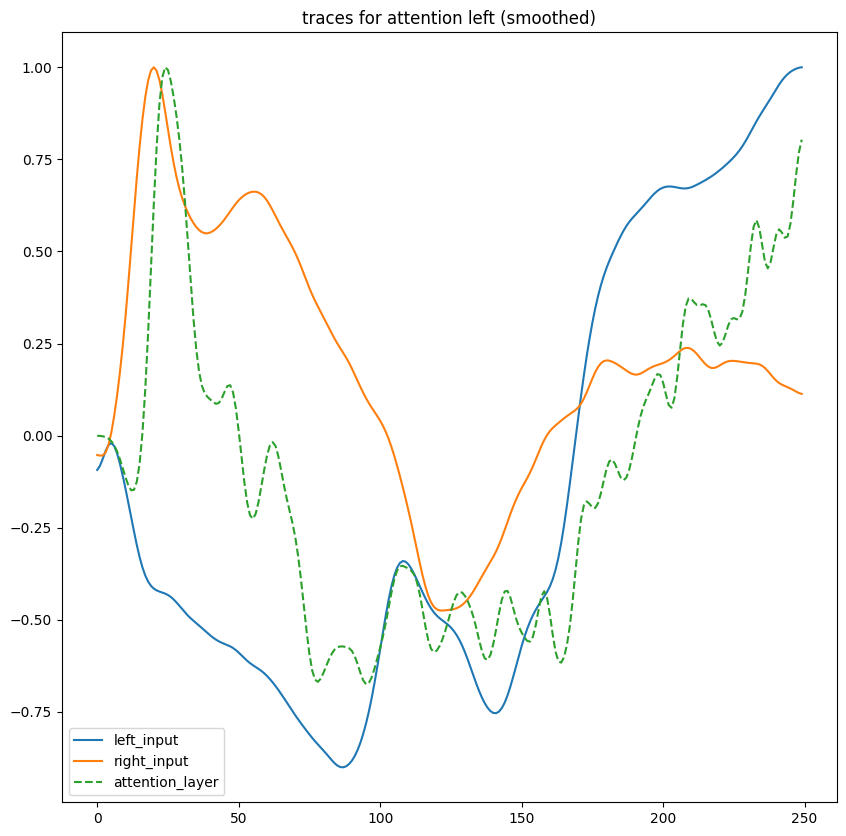

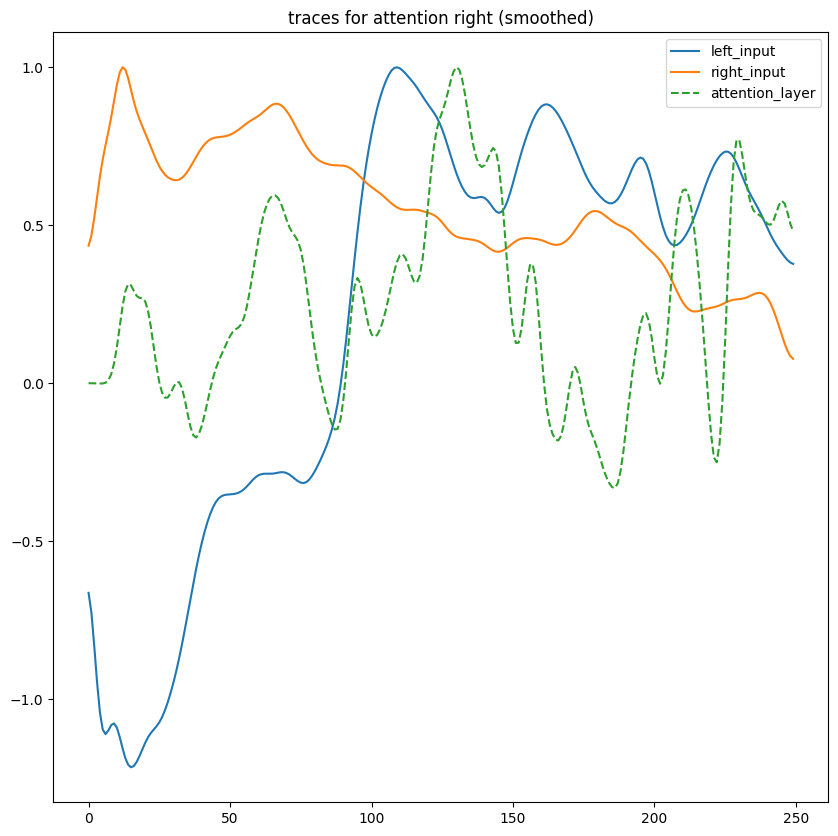

In [70]:
#-------------wsmi calculation----------------
n_times = 250
dt = 0.002
sfreq = 1 / dt

ch_names = ['left_input', 'right_input', 'attention_layer']
ch_types = ['eeg', 'eeg', 'eeg']
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

lr_split_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for class_right in classes_right} for class_left in classes_left}


for class_left in classes_left:
    wsmi_start = time.time()
    for class_right in classes_right: 
     
        #reshaping data for attention left
        raw_data_left = np.concatenate([
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'], 
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] ,
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] 
            ], axis=0)

        #print("raw_data_left shape =", raw_data_left.shape)  
        #Reshape into (n_channels, n_samples)
        raw_data_left = raw_data_left.reshape(3, -1)  
        #print('raw data left reshaped =', raw_data_left.shape) 
        raw_left = mne.io.RawArray(raw_data_left, info)
        #print("raw_data_left =", raw_left)


        events_left = np.array([[i * n_times, 0, 1] for i in range(n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft']) ])
        epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.498, baseline=None, preload=True)

        # if class_left == 0 and class_right == 1:
        #     print('raw_data_left =', raw_data_left)
        #     print('raw_data_left reshaped =', raw_data_left.shape)
        #     print('raw_left =', raw_left)
        #     #defininf event objects, arrays like [0,0,1], [500, 0, 1], [1000, 0, 1] etc
        #     epochs_left.plot(n_epochs = 2, n_channels=3, scalings = 'auto', title="Attention Left")
        #     plt.show()

        if class_left == left and class_right == right:
            plt.figure(figsize=(10, 10))
            NL = np.max(smooth_with_gaussian(raw_data_left[0][0:250]))
            NR = np.max(smooth_with_gaussian(raw_data_left[1][0:250]))
            NA = np.max(smooth_with_gaussian(raw_data_left[2][0:250]))
            plt.plot(smooth_with_gaussian((raw_data_left[0][0:250] / NL)), label='left_input')
            plt.plot(smooth_with_gaussian((raw_data_left[1][0:250] / NR)), label='right_input')
            plt.plot(smooth_with_gaussian(raw_data_left[2][0:250] / NA), label='attention_layer', linestyle='--')
            plt.title('traces for attention left (smoothed)')
            plt.legend()
            plt.show()


for class_left in classes_left:
    wsmi_start = time.time()
    for class_right in classes_right:

        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] == 0:  #right class pairs that have trials
            print('no trials for this class pair')
            continue        

        #reshaping date for attention right 
        raw_data_right = np.concatenate([
            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] 
        ], axis=0)

        #print('raw_data_right shape =', raw_data_right.shape)
        raw_data_right = raw_data_right.reshape(3, -1)
        #print('raw_data_right reshaped =', raw_data_right.shape)
        raw_right = mne.io.RawArray(raw_data_right, info)
        #print('raw_data_right =', raw_right)


        events_right = np.array([[i * n_times, 0, 1] for i in range(n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright']) ]) 
        epochs_right = mne.Epochs(raw_right, events_right, event_id={'Trial': 1}, tmin=0, tmax = 0.498, baseline=None, preload=True)

        if class_left == left and class_right == right:
            plt.figure(figsize=(10, 10))
            NL = np.max(smooth_with_gaussian(raw_data_right[0][0:250]))
            NR = np.max(smooth_with_gaussian(raw_data_right[1][0:250]))
            NA = np.max(smooth_with_gaussian(raw_data_right[2][0:250]))
            plt.plot(smooth_with_gaussian((raw_data_right[0][0:250] / NL)), label='left_input')
            plt.plot(smooth_with_gaussian((raw_data_right[1][0:250] / NR)), label='right_input')
            plt.plot(smooth_with_gaussian(raw_data_right[2][0:250] / NA), label='attention_layer', linestyle='--')
            plt.title('traces for attention right (smoothed)')
            plt.legend()
            plt.show()